# Tunisia data

In [47]:
import dataset
import datetime
from datetime import timedelta
from parser import get_parser
import numpy as np 
import pandas as pd 
import torch
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt 
from utils import *
from pygData_util import *
import seaborn as sns

In [48]:
sns.set_style("whitegrid")

In [49]:
data = dataset.Tdata(path='../Custom-Semi-Supervised/data/tdata.csv')
parser = get_parser()
args = parser.parse_args(args=
                         ["--data","real-t", 
                          "--sampling","xgb",
                          "--mode","scratch",
                          "--train_from","20170101",
                          "--test_from","20190101",
                          "--test_length","365",
                          "--valid_length","90",
                          "--initial_inspection_rate", "5",
                          "--final_inspection_rate", "10",
                         ])

In [50]:
# args
seed = args.seed
initial_inspection_rate = args.initial_inspection_rate
inspection_rate_option = args.inspection_plan
mode = args.mode
train_begin = args.train_from 
test_begin = args.test_from
test_length = args.test_length
valid_length = args.valid_length
chosen_data = args.data
numWeeks = args.numweeks

# Initial dataset split
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Initial dataset split
train_start_day = datetime.date(int(train_begin[:4]), int(train_begin[4:6]), int(train_begin[6:8]))
test_start_day = datetime.date(int(test_begin[:4]), int(test_begin[4:6]), int(test_begin[6:8]))
test_length = timedelta(days=test_length)    
test_end_day = test_start_day + test_length
valid_length = timedelta(days=valid_length)
valid_start_day = test_start_day - valid_length

# data
data.split(train_start_day, valid_start_day, test_start_day, test_end_day, valid_length, test_length, args)
data.featureEngineering()

Data size:
Train labeled: (77391, 41), Train unlabeled: (1470434, 41), Valid labeled: (134457, 41), Valid unlabeled: (0, 13), Test: (703090, 41)
Checking label distribution
Training: 0.09757342825942052
Validation: 0.09589052260946108
Testing: 0.10476480792437651


In [51]:
categories=["importer.id","HS6"]
gdata = GraphData(data,use_xgb=False, categories=categories)

### Average unseen category 
In the following cell, I calculate the ratio of unseen importer/hs in test data.<br>
* Although there are lots of new importers, they only account for a small protion.
* However, in N data, the unseen importer took a large protion in test data.

Since DATE learns **unique embeddings** for importer/hs, we should expect **DATE perform well when the unseen rate is low.**

In [52]:
print("[valid] Unseen importer rate: %.4f" % (1 - gdata.valid_user.nonzero().shape[0] / data.valid.shape[0]))
print("[Valid] Unseen HS code rate: %.4f" % (1 - gdata.valid_item.nonzero().shape[0] / data.valid.shape[0]))
print("[test] Unseen importer rate: %.4f" % (1 - gdata.test_user.nonzero().shape[0] / data.test.shape[0]))
print("[test] Unseen HS code rate: %.4f" % (1 - gdata.test_item.nonzero().shape[0] / data.test.shape[0]))

[valid] Unseen importer rate: 0.0782
[Valid] Unseen HS code rate: 0.0270
[test] Unseen importer rate: 0.0997
[test] Unseen HS code rate: 0.0284


### Importer Analysis
Calculate the frequency of importers appraning in the training set.<br>
Note that interval **\[0,1)** denotes the new importer, i.e. the frequency appearing in training set is 0. <br>
* In the **top-right figure**, the majority of transactions are maed by importers that lies in subgroup [10,50).
* The **bottom-right figure** shows that the new importers have the highest illicit rate, but the # transactions of new importers is small. <br>
Therefore, having a high illicit rate might not be help for overall prediction.

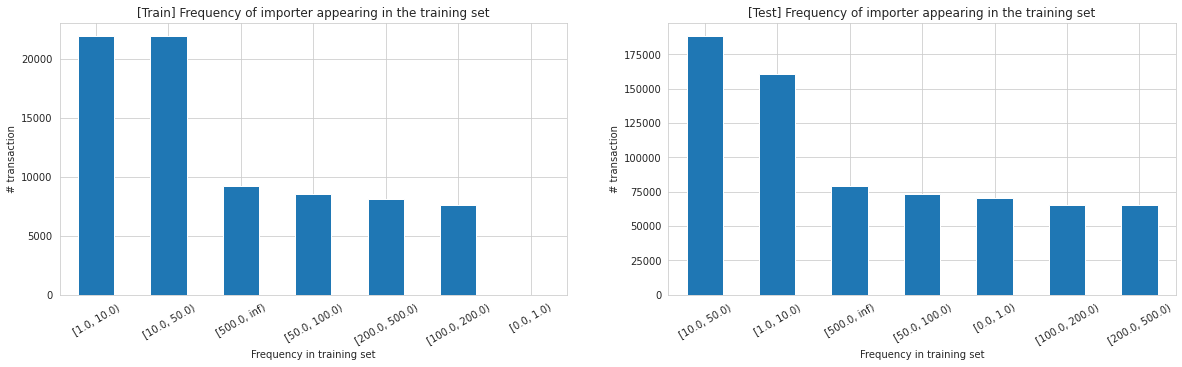

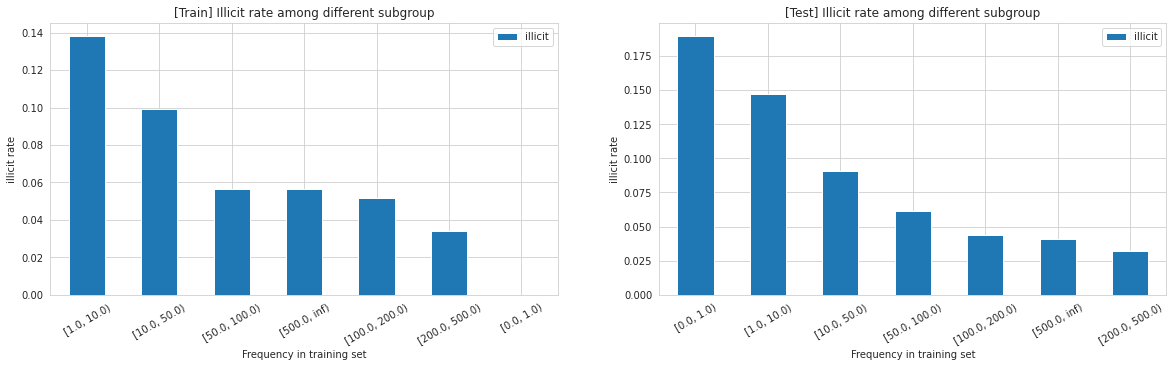

In [53]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_user.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_user.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_user.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax1)
plt.title("[Train] Frequency of importer appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)

# plot 
ax2 = fig.add_subplot(1,2,2)
cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax2)
plt.title("[Test] Frequency of importer appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

# plots
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
plt.xticks(rotation=30)
train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
train_summary.plot(kind="bar",ax=ax1)
plt.title("[Train] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
ax2 = fig.add_subplot(1,2,2)
test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
test_summary.plot(kind="bar",ax=ax2)
plt.title("[Test] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

### HS code Analysis

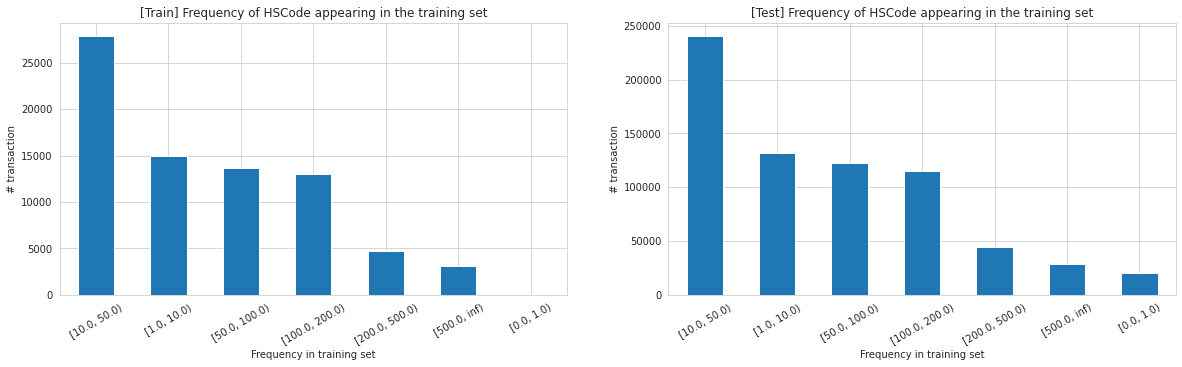

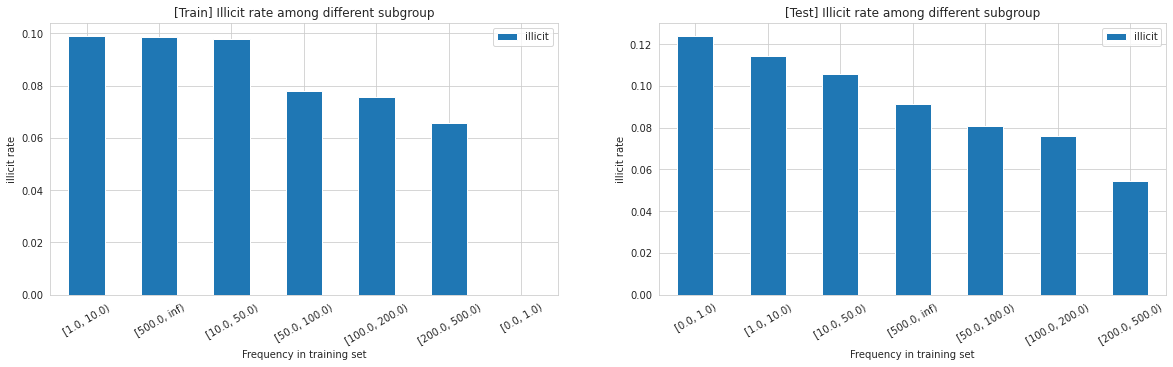

In [54]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_item.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_item.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_item.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax1)
plt.title("[Train] Frequency of HSCode appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)

# plot 
ax2 = fig.add_subplot(1,2,2)
cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax2)
plt.title("[Test] Frequency of HSCode appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
plt.xticks(rotation=30)
train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
train_summary.plot(kind="bar",ax=ax1)
plt.title("[Train] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
ax2 = fig.add_subplot(1,2,2)
test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
test_summary.plot(kind="bar",ax=ax2)
plt.title("[Test] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

## Prediction Analysis
Here I would like to present some analysis of predictions made by DATE and GNN model.<br>
The flow of analysis is presented as follows:
1. Overall evaluation result. (just for reference to let you know which is performing better)
2. Correlation of predictions on illicit transaction.
3. Evaluating precision/recall in different subgroups.
4. Comparing the distribution in different subgroups.

In [44]:
from utils import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from scipy.stats import pearsonr

In [63]:
# obtain DATE prediction
DATE_prediction = np.load("../Customs-Fraud-Detection/analysis/Tdata5_DATE_prediction.npy")
GNN_prediction = np.load("./analysis/Tdata5_GNN_prediction.npy")
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
r, p_value = pearsonr(DATE_prediction,GNN_prediction)
print("Correlation:%.4f" % r)

# overall stats
print("GNN results...")
gnn_result = metrics(GNN_prediction, data.test_cls_label, data.test_reg_label,None)
print("-"*50)
print("DATE results...")
DATE_result = metrics(DATE_prediction, data.test_cls_label, data.test_reg_label,None)

Correlation:0.8318
GNN results...
Checking top 1% suspicious transactions: 7031
Precision: 0.7185, Recall: 0.0758, Revenue: 0.1338
Checking top 2% suspicious transactions: 14062
Precision: 0.6298, Recall: 0.1328, Revenue: 0.2257
Checking top 5% suspicious transactions: 35155
Precision: 0.4715, Recall: 0.2486, Revenue: 0.3899
Checking top 10% suspicious transactions: 70309
Precision: 0.3403, Recall: 0.3589, Revenue: 0.5179
--------------------------------------------------
DATE results...
Checking top 1% suspicious transactions: 7031
Precision: 0.8067, Recall: 0.0851, Revenue: 0.1666
Checking top 2% suspicious transactions: 14062
Precision: 0.7023, Recall: 0.1481, Revenue: 0.2625
Checking top 5% suspicious transactions: 35155
Precision: 0.4944, Recall: 0.2607, Revenue: 0.3978
Checking top 10% suspicious transactions: 70309
Precision: 0.3532, Recall: 0.3724, Revenue: 0.5155


Correlation:0.8693


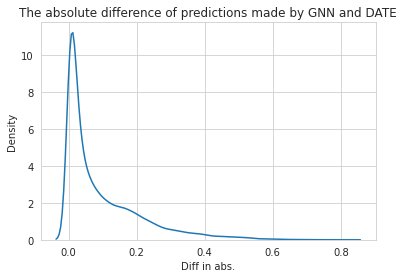

In [60]:
# calculate the correlation of illicit transaction to see if they're making similar predict
illicit_transaction = data.test_cls_label == 1
r, p_value = pearsonr(DATE_prediction[illicit_transaction],GNN_prediction[illicit_transaction])
print("Correlation:%.4f" % r)

diff = np.abs(DATE_prediction[illicit_transaction]-GNN_prediction[illicit_transaction])
sns.kdeplot(diff)
plt.title("The absolute difference of predictions made by GNN and DATE")
plt.xlabel("Diff in abs.")
plt.show()

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 200
Precision: 0.5150, Recall: 0.0416, Revenue: 0.0616
Checking top 2% suspicious transactions: 400
Precision: 0.4550, Recall: 0.0735, Revenue: 0.1015
Checking top 5% suspicious transactions: 998
Precision: 0.3687, Recall: 0.1487, Revenue: 0.1965
Checking top 10% suspicious transactions: 1996
Precision: 0.2906, Recall: 0.2343, Revenue: 0.2985
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 200
Precision: 0.5950, Recall: 0.0481, Revenue: 0.0871
Checking top 2% suspicious transactions: 400
Precision: 0.4750, Recall: 0.0768, Revenue: 0.1315
Checking top 5% suspicious transactions: 998
Precision: 0.3758, Recall: 0.1515, Revenue: 0.2205
Checking top 10% suspicious transactions: 1996
Precision: 0.2926, Recall: 0.2360, Revenue: 0.2993


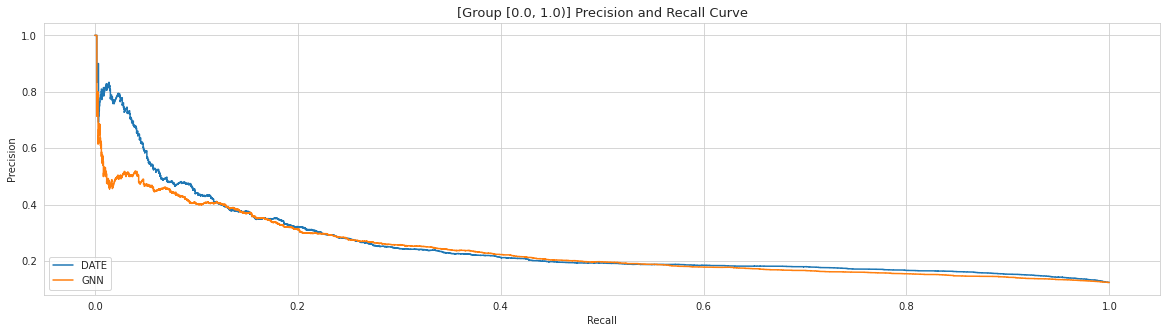

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1320
Precision: 0.6992, Recall: 0.0611, Revenue: 0.1115
Checking top 2% suspicious transactions: 2639
Precision: 0.6480, Recall: 0.1132, Revenue: 0.1939
Checking top 5% suspicious transactions: 6596
Precision: 0.5186, Recall: 0.2264, Revenue: 0.3450
Checking top 10% suspicious transactions: 13192
Precision: 0.3896, Recall: 0.3401, Revenue: 0.4821
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1320
Precision: 0.8189, Recall: 0.0715, Revenue: 0.1411
Checking top 2% suspicious transactions: 2639
Precision: 0.7014, Recall: 0.1225, Revenue: 0.2239
Checking top 5% suspicious transactions: 6596
Precision: 0.5332, Recall: 0.2327, Revenue: 0.3512
Checking top 10% suspicious transactions: 13192
Precision: 0.4078, Recall: 0.3560, Revenue: 0.4801


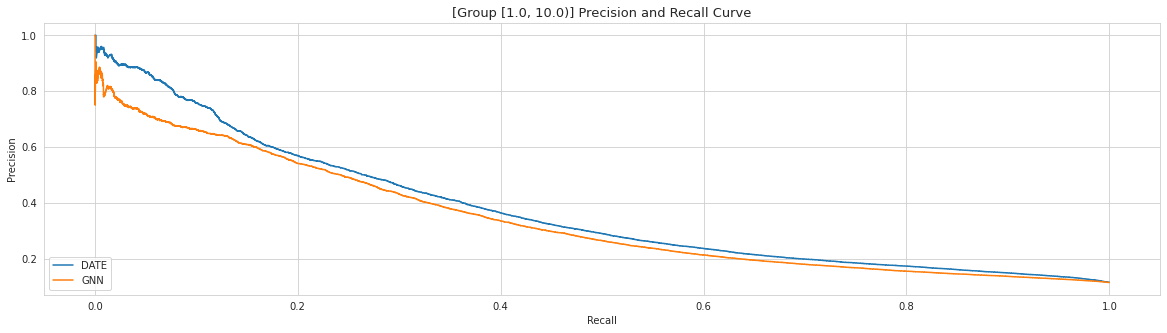

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 2408
Precision: 0.7853, Recall: 0.0744, Revenue: 0.1165
Checking top 2% suspicious transactions: 4816
Precision: 0.7147, Recall: 0.1355, Revenue: 0.2020
Checking top 5% suspicious transactions: 12039
Precision: 0.5696, Recall: 0.2699, Revenue: 0.3905
Checking top 10% suspicious transactions: 24077
Precision: 0.4187, Recall: 0.3968, Revenue: 0.5364
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 2408
Precision: 0.8335, Recall: 0.0790, Revenue: 0.1457
Checking top 2% suspicious transactions: 4816
Precision: 0.7826, Recall: 0.1483, Revenue: 0.2386
Checking top 5% suspicious transactions: 12039
Precision: 0.5926, Recall: 0.2808, Revenue: 0.3900
Checking top 10% suspicious transactions: 24077
Precision: 0.4278, Recall: 0.4054, Revenue: 0.5262


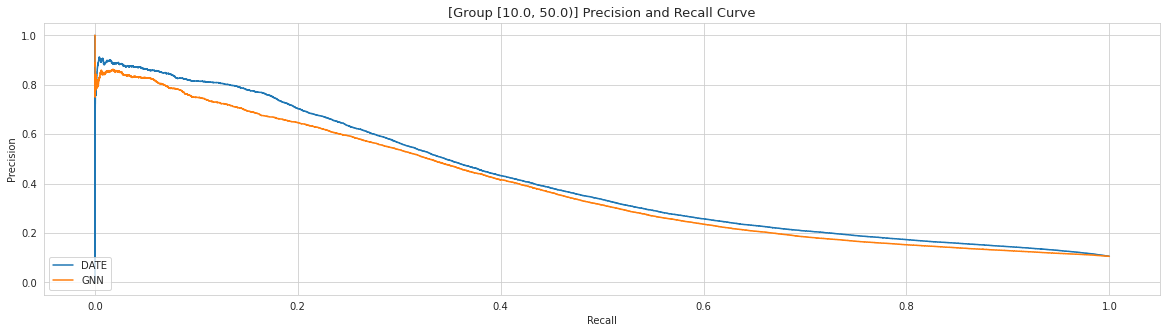

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1225
Precision: 0.6947, Recall: 0.0862, Revenue: 0.1781
Checking top 2% suspicious transactions: 2449
Precision: 0.5745, Recall: 0.1426, Revenue: 0.2752
Checking top 5% suspicious transactions: 6122
Precision: 0.3982, Recall: 0.2471, Revenue: 0.4369
Checking top 10% suspicious transactions: 12244
Precision: 0.2866, Recall: 0.3556, Revenue: 0.5581
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1225
Precision: 0.7698, Recall: 0.0956, Revenue: 0.1947
Checking top 2% suspicious transactions: 2449
Precision: 0.6329, Recall: 0.1571, Revenue: 0.3032
Checking top 5% suspicious transactions: 6122
Precision: 0.4265, Recall: 0.2646, Revenue: 0.4396
Checking top 10% suspicious transactions: 12244
Precision: 0.3112, Recall: 0.3861, Revenue: 0.5640


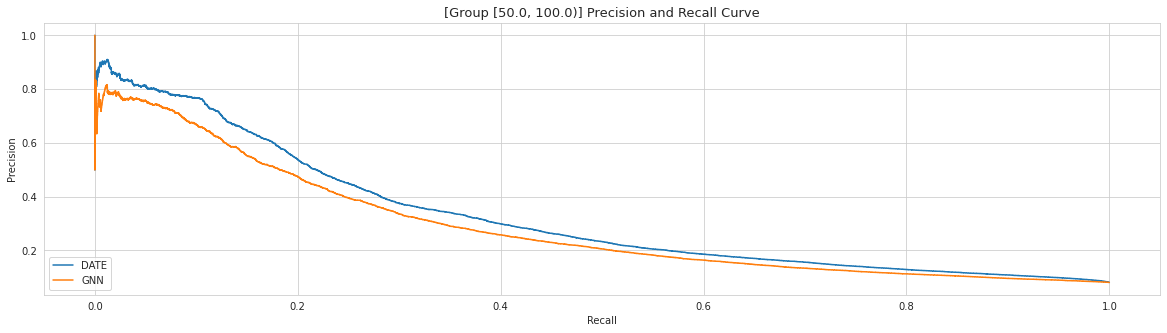

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1154
Precision: 0.6023, Recall: 0.0790, Revenue: 0.1675
Checking top 2% suspicious transactions: 2308
Precision: 0.5022, Recall: 0.1318, Revenue: 0.2693
Checking top 5% suspicious transactions: 5769
Precision: 0.3588, Recall: 0.2354, Revenue: 0.4295
Checking top 10% suspicious transactions: 11538
Precision: 0.2556, Recall: 0.3353, Revenue: 0.5540
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1154
Precision: 0.7617, Recall: 0.1000, Revenue: 0.2407
Checking top 2% suspicious transactions: 2308
Precision: 0.5893, Recall: 0.1547, Revenue: 0.3309
Checking top 5% suspicious transactions: 5769
Precision: 0.3812, Recall: 0.2501, Revenue: 0.4592
Checking top 10% suspicious transactions: 11538
Precision: 0.2643, Recall: 0.3468, Revenue: 0.5614


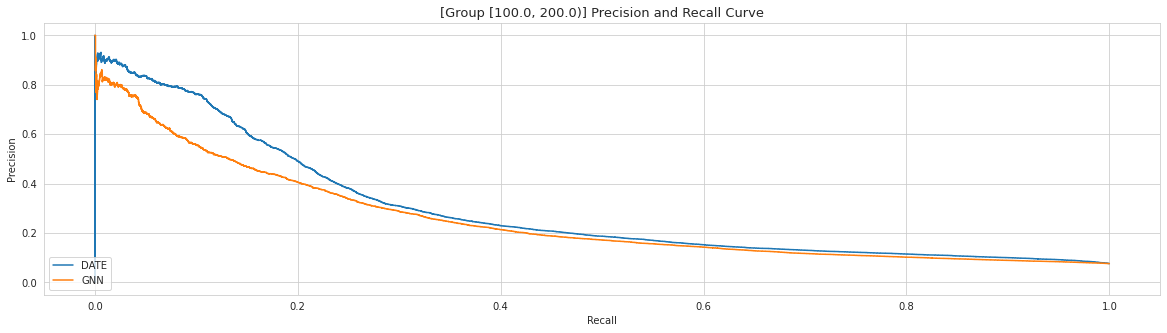

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...
Checking top 1% suspicious transactions: 441
Precision: 0.4603, Recall: 0.0842, Revenue: 0.2010
Checking top 2% suspicious transactions: 882
Precision: 0.3560, Recall: 0.1302, Revenue: 0.3029
Checking top 5% suspicious transactions: 2205
Precision: 0.2376, Recall: 0.2172, Revenue: 0.4226
Checking top 10% suspicious transactions: 4410
Precision: 0.1707, Recall: 0.3122, Revenue: 0.5444
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 441
Precision: 0.6327, Recall: 0.1157, Revenue: 0.2918
Checking top 2% suspicious transactions: 882
Precision: 0.4354, Recall: 0.1592, Revenue: 0.3557
Checking top 5% suspicious transactions: 2205
Precision: 0.2549, Recall: 0.2330, Revenue: 0.4726
Checking top 10% suspicious transactions: 4410
Precision: 0.1819, Recall: 0.3325, Revenue: 0.5689


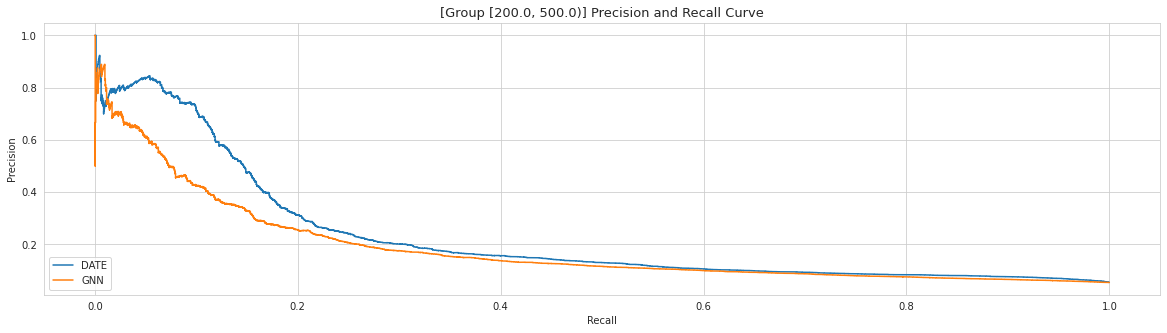

===============Evaluating subgroup:[500.0, inf)===============
GNN Results...
Checking top 1% suspicious transactions: 286
Precision: 0.6888, Recall: 0.0756, Revenue: 0.1538
Checking top 2% suspicious transactions: 571
Precision: 0.6305, Recall: 0.1381, Revenue: 0.2527
Checking top 5% suspicious transactions: 1427
Precision: 0.4527, Recall: 0.2479, Revenue: 0.4190
Checking top 10% suspicious transactions: 2854
Precision: 0.3255, Recall: 0.3565, Revenue: 0.5818
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 286
Precision: 0.8182, Recall: 0.0898, Revenue: 0.2169
Checking top 2% suspicious transactions: 571
Precision: 0.6392, Recall: 0.1401, Revenue: 0.2933
Checking top 5% suspicious transactions: 1427
Precision: 0.4156, Recall: 0.2276, Revenue: 0.3747
Checking top 10% suspicious transactions: 2854
Precision: 0.3038, Recall: 0.3327, Revenue: 0.5024


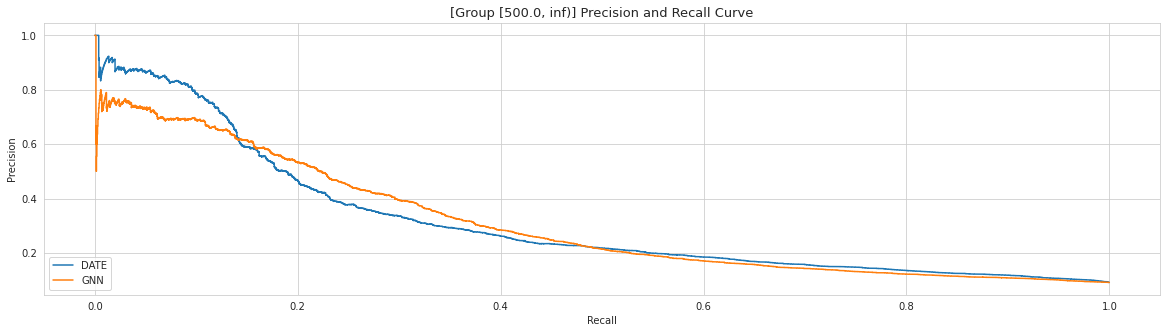

In [61]:
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()

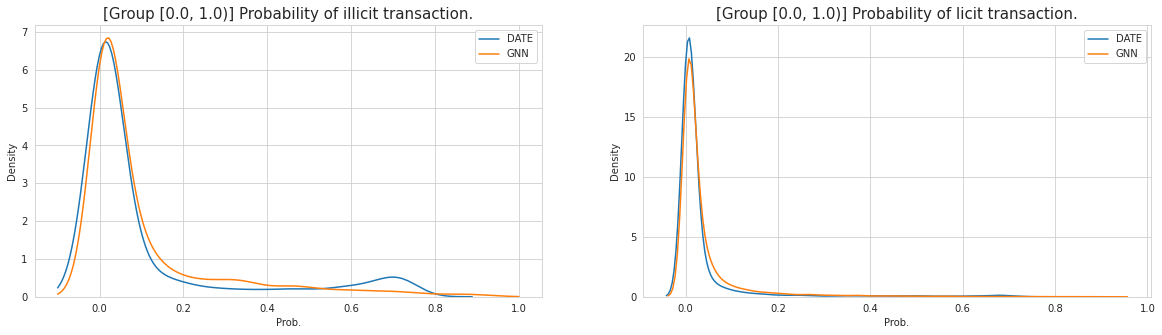

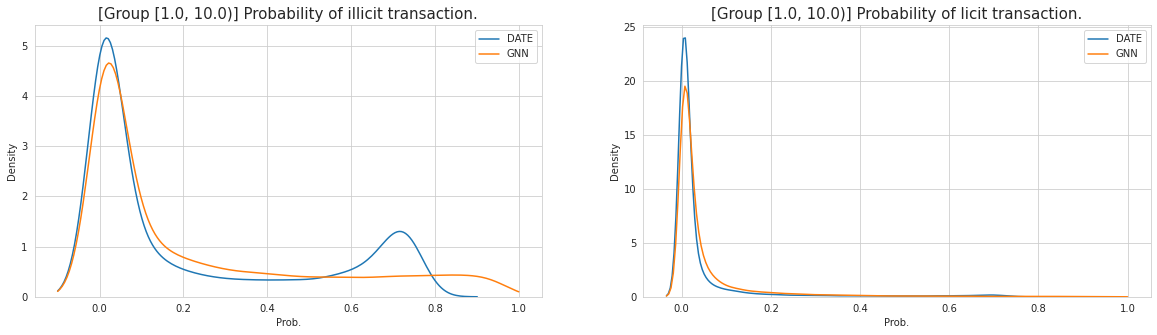

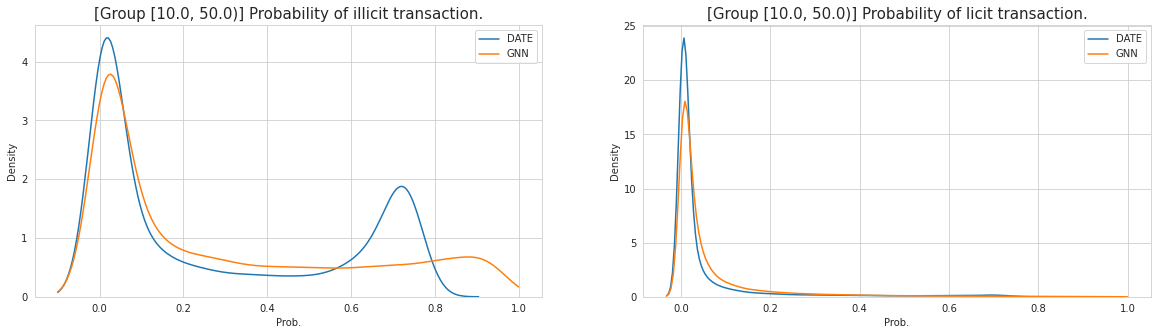

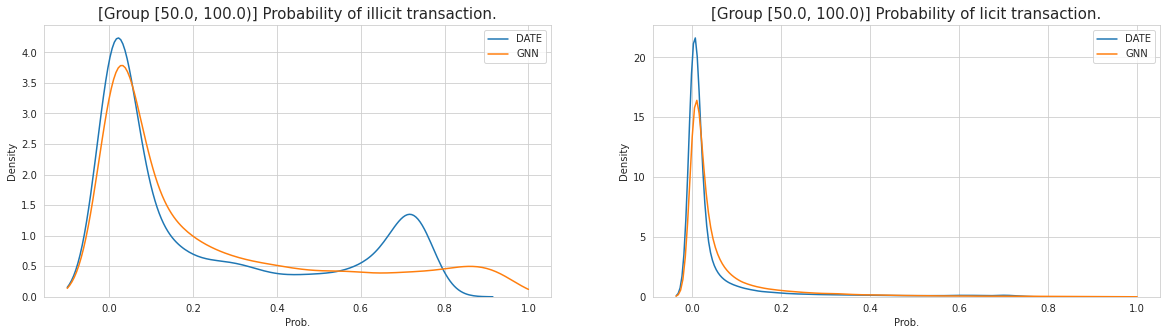

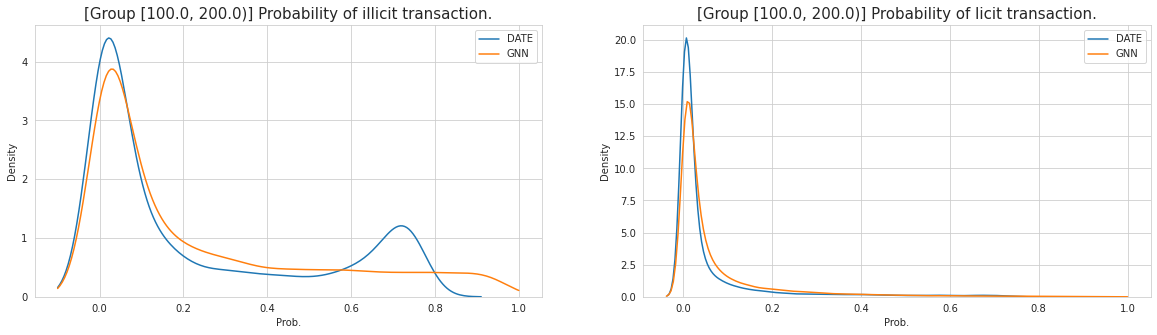

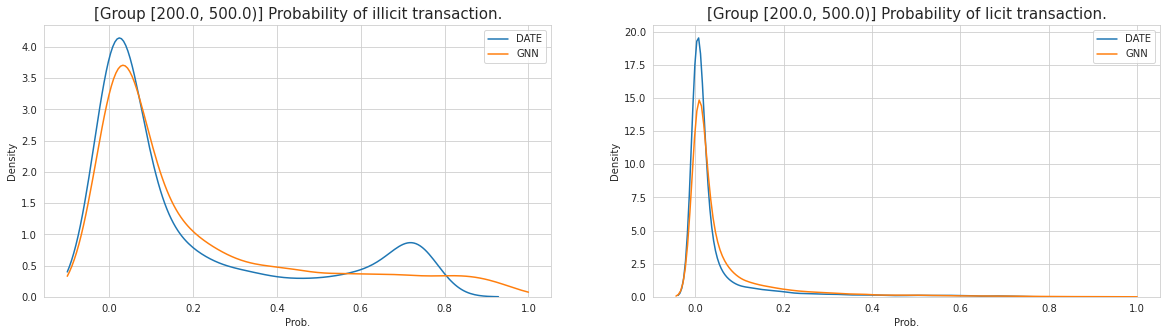

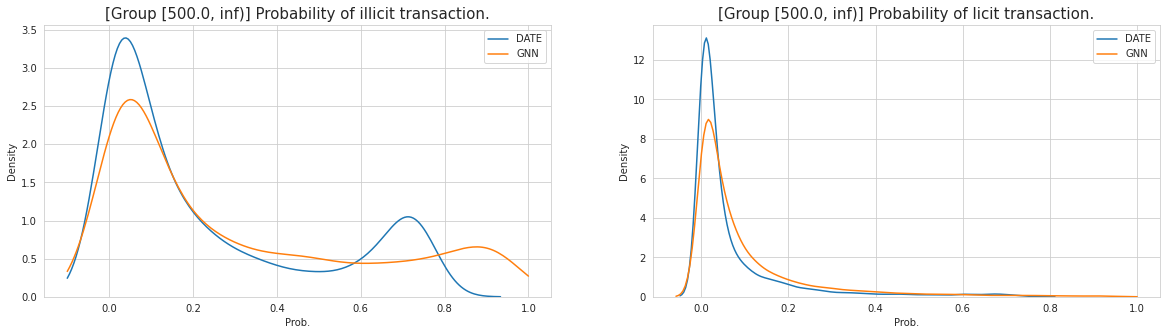

In [62]:
for groupID, subgroup in analysis.groupby("bins"):
    fig = plt.figure(figsize=(20,5))
    
    # illicit
    illict_ax = fig.add_subplot(1,2,1)
    illicit_group = subgroup[subgroup["cls_label"] == 1]
    sns.kdeplot(illicit_group["DATE"], label = "DATE",ax=illict_ax, clip=(-0.1,1))
    sns.kdeplot(illicit_group["gnn"], label = "GNN",ax=illict_ax, clip=(-0.1,1))
    plt.xlabel("Prob.")
    plt.title("[Group %s] Probability of illicit transaction." % groupID, fontsize = 15)
    plt.legend()
    
    # licit
    lict_ax = fig.add_subplot(1,2,2)
    licit_group = subgroup[subgroup["cls_label"] == 0]
    sns.kdeplot(licit_group["DATE"], label = "DATE",ax=lict_ax, clip=(-0.1,1))
    sns.kdeplot(licit_group["gnn"], label = "GNN",ax=lict_ax, clip=(-0.1,1))
    plt.xlabel("Prob.")
    plt.title("[Group %s] Probability of licit transaction." % groupID, fontsize = 15)
    plt.legend()

# Nigeria Dataset

In [18]:
data = dataset.Ndata(path='../Custom-Semi-Supervised/data/ndata.csv')
parser = get_parser()
args = parser.parse_args(args=
                         ["--data","real-n", 
                          "--sampling","xgb",
                          "--mode","scratch",
                          "--train_from","20140101",
                          "--test_from","20170101",
                          "--test_length","365",
                          "--valid_length","90",
                          "--initial_inspection_rate", "5",
                          "--final_inspection_rate", "10",
                         ])

In [19]:
# args
seed = args.seed
initial_inspection_rate = args.initial_inspection_rate
inspection_rate_option = args.inspection_plan
mode = args.mode
train_begin = args.train_from 
test_begin = args.test_from
test_length = args.test_length
valid_length = args.valid_length
chosen_data = args.data
numWeeks = args.numweeks

# Initial dataset split
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Initial dataset split
train_start_day = datetime.date(int(train_begin[:4]), int(train_begin[4:6]), int(train_begin[6:8]))
test_start_day = datetime.date(int(test_begin[:4]), int(test_begin[4:6]), int(test_begin[6:8]))
test_length = timedelta(days=test_length)    
test_end_day = test_start_day + test_length
valid_length = timedelta(days=valid_length)
valid_start_day = test_start_day - valid_length

# data
data.split(train_start_day, valid_start_day, test_start_day, test_end_day, valid_length, test_length, args)
data.featureEngineering()

Data size:
Train labeled: (54134, 52), Train unlabeled: (1028538, 52), Valid labeled: (70917, 52), Valid unlabeled: (0, 26), Test: (274808, 52)
Checking label distribution
Training: 0.05022795615481618
Validation: 0.035556788645191434
Testing: 0.025360899366070794


In [20]:
categories=["importer.id","HS6"]
gdata = GraphData(data,use_xgb=False, categories=categories)

### Average unseen category 

In [21]:
print("[valid] Unseen importer rate: %.4f" % (1 - gdata.valid_user.nonzero().shape[0] / data.valid.shape[0]))
print("[Valid] Unseen HS code rate: %.4f" % (1 - gdata.valid_item.nonzero().shape[0] / data.valid.shape[0]))
print("[test] Unseen importer rate: %.4f" % (1 - gdata.test_user.nonzero().shape[0] / data.test.shape[0]))
print("[test] Unseen HS code rate: %.4f" % (1 - gdata.test_item.nonzero().shape[0] / data.test.shape[0]))

[valid] Unseen importer rate: 0.3431
[Valid] Unseen HS code rate: 0.0223
[test] Unseen importer rate: 0.4943
[test] Unseen HS code rate: 0.0364


### Importer Analysis

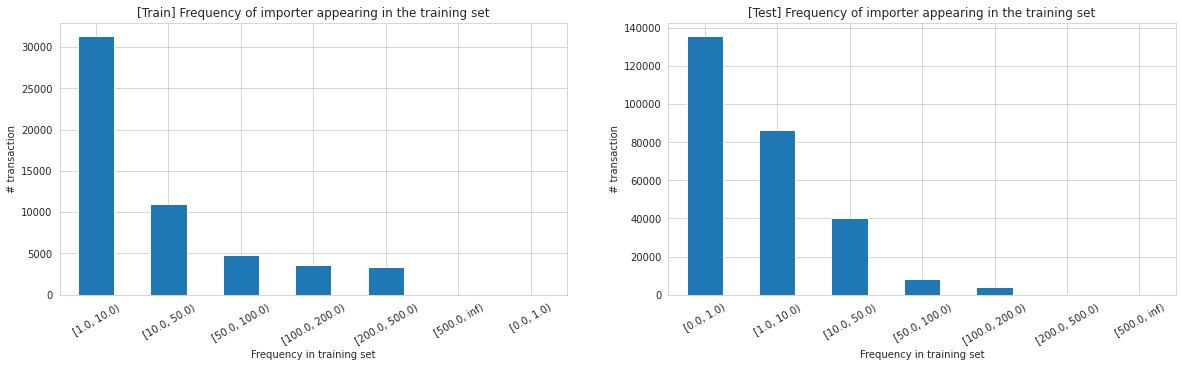

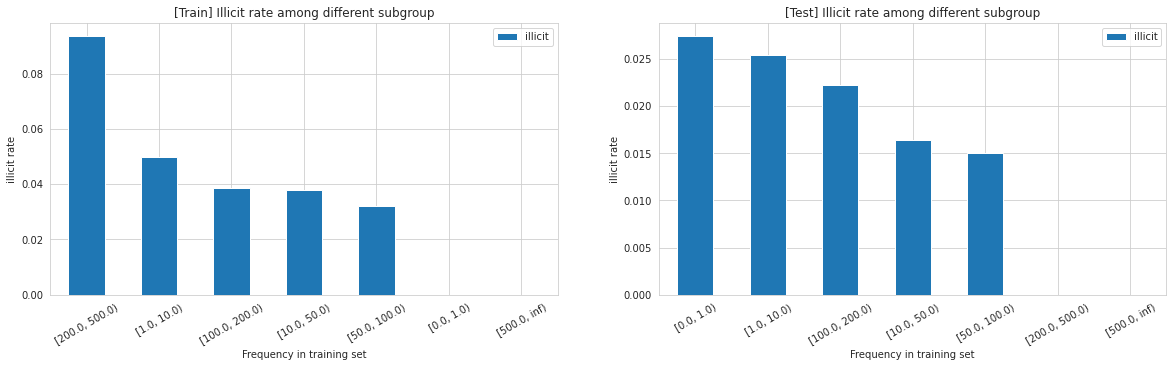

In [23]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_user.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_user.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_user.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax1)
plt.title("[Train] Frequency of importer appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)

# plot 
ax2 = fig.add_subplot(1,2,2)
cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax2)
plt.title("[Test] Frequency of importer appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

# plots
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
plt.xticks(rotation=30)
train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
train_summary.plot(kind="bar",ax=ax1)
plt.title("[Train] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
ax2 = fig.add_subplot(1,2,2)
test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
test_summary.plot(kind="bar",ax=ax2)
plt.title("[Test] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

### HS code Analysis

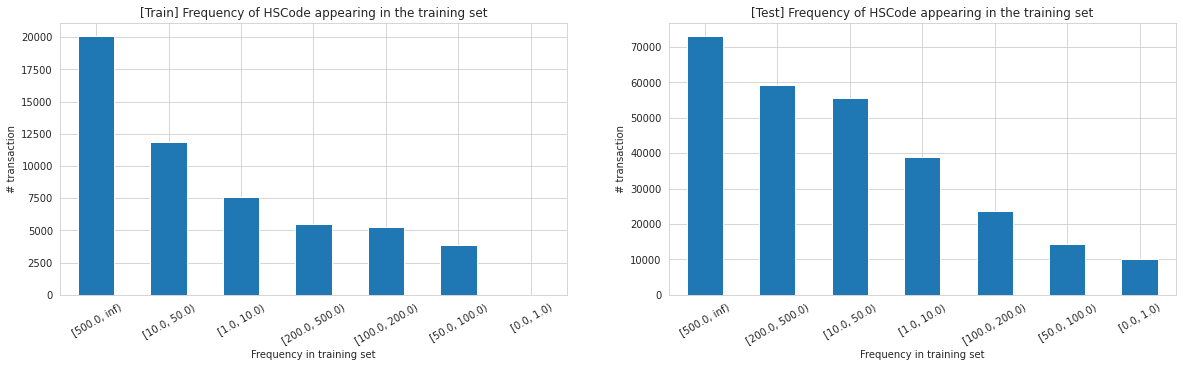

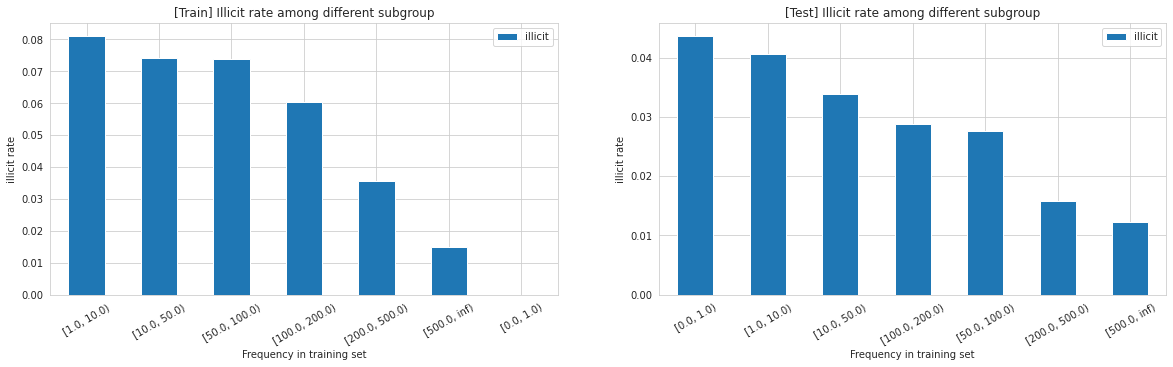

In [24]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_item.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_item.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_item.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax1)
plt.title("[Train] Frequency of HSCode appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)

# plot 
ax2 = fig.add_subplot(1,2,2)
cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar",ax=ax2)
plt.title("[Test] Frequency of HSCode appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
plt.xticks(rotation=30)
train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
train_summary.plot(kind="bar",ax=ax1)
plt.title("[Train] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
ax2 = fig.add_subplot(1,2,2)
test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
test_summary.plot(kind="bar",ax=ax2)
plt.title("[Test] Illicit rate among different subgroup")
plt.ylabel("illicit rate")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

## Prediction Analysis

In [26]:
from utils import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from scipy.stats import pearsonr

In [37]:
# obtain DATE prediction
DATE_prediction = np.load("../Customs-Fraud-Detection/analysis/Ndata5_DATE_prediction.npy")
GNN_prediction = np.load("./analysis/Ndata5_GNN_prediction.npy")
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
r, p_value = pearsonr(DATE_prediction,GNN_prediction)
print("Correlation:%.4f" % r)

# overall stats
print("GNN results...")
_ = metrics(GNN_prediction, data.test_cls_label, data.test_reg_label,None)
print("-"*50)
print("DATE results...")
_ = metrics(DATE_prediction, data.test_cls_label, data.test_reg_label,None)

Correlation:0.5217
GNN results...
Checking top 1% suspicious transactions: 2749
Precision: 0.3496, Recall: 0.1414, Revenue: 0.1501
Checking top 2% suspicious transactions: 5497
Precision: 0.3154, Recall: 0.2551, Revenue: 0.2277
Checking top 5% suspicious transactions: 13741
Precision: 0.2025, Recall: 0.4094, Revenue: 0.3586
Checking top 10% suspicious transactions: 27481
Precision: 0.1247, Recall: 0.5040, Revenue: 0.4197
--------------------------------------------------
DATE results...
Checking top 1% suspicious transactions: 2749
Precision: 0.1837, Recall: 0.0743, Revenue: 0.1262
Checking top 2% suspicious transactions: 5497
Precision: 0.1554, Recall: 0.1256, Revenue: 0.1905
Checking top 5% suspicious transactions: 13722
Precision: 0.1423, Recall: 0.2872, Revenue: 0.3011
Checking top 10% suspicious transactions: 27481
Precision: 0.1263, Recall: 0.5107, Revenue: 0.4519


Correlation:0.6042


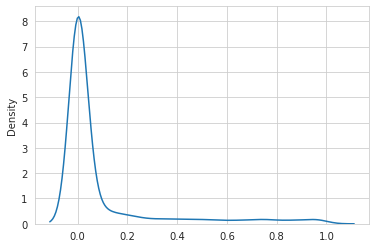

In [28]:
# calculate the correlation of illicit transaction to see if they're making similar predict
illicit_transaction = data.test_cls_label == 1
r, p_value = pearsonr(DATE_prediction[illicit_transaction],GNN_prediction[illicit_transaction])
print("Correlation:%.4f" % r)

diff = np.abs(DATE_prediction[illicit_transaction]-GNN_prediction[illicit_transaction])
sns.kdeplot(diff)
plt.show()

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 101
Precision: 0.4158, Recall: 0.0961, Revenue: 0.1214
Checking top 2% suspicious transactions: 201
Precision: 0.2886, Recall: 0.1327, Revenue: 0.1485
Checking top 5% suspicious transactions: 501
Precision: 0.2196, Recall: 0.2517, Revenue: 0.3539
Checking top 10% suspicious transactions: 1001
Precision: 0.1678, Recall: 0.3844, Revenue: 0.4071
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 101
Precision: 0.2871, Recall: 0.0664, Revenue: 0.1322
Checking top 2% suspicious transactions: 201
Precision: 0.2090, Recall: 0.0961, Revenue: 0.1844
Checking top 5% suspicious transactions: 501
Precision: 0.1178, Recall: 0.1350, Revenue: 0.2159
Checking top 10% suspicious transactions: 1001
Precision: 0.1469, Recall: 0.3364, Revenue: 0.3393


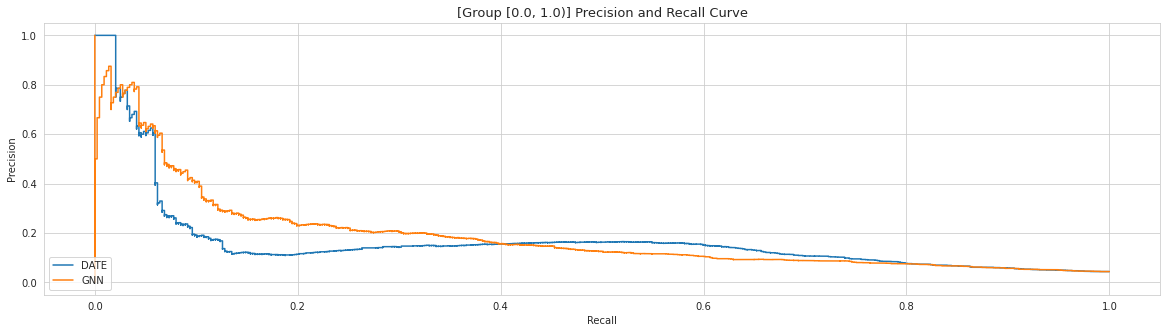

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 390
Precision: 0.3128, Recall: 0.0772, Revenue: 0.1204
Checking top 2% suspicious transactions: 780
Precision: 0.2449, Recall: 0.1209, Revenue: 0.1668
Checking top 5% suspicious transactions: 1950
Precision: 0.1877, Recall: 0.2316, Revenue: 0.2802
Checking top 10% suspicious transactions: 3899
Precision: 0.1529, Recall: 0.3772, Revenue: 0.3881
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 390
Precision: 0.2949, Recall: 0.0728, Revenue: 0.1052
Checking top 2% suspicious transactions: 780
Precision: 0.1949, Recall: 0.0962, Revenue: 0.1409
Checking top 5% suspicious transactions: 1950
Precision: 0.1303, Recall: 0.1608, Revenue: 0.2179
Checking top 10% suspicious transactions: 3899
Precision: 0.1111, Recall: 0.2741, Revenue: 0.3201


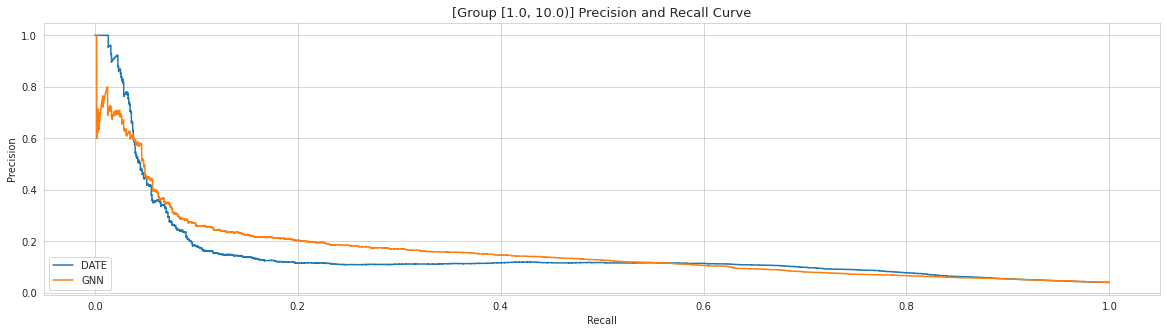

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 556
Precision: 0.2212, Recall: 0.0655, Revenue: 0.1345
Checking top 2% suspicious transactions: 1112
Precision: 0.1574, Recall: 0.0932, Revenue: 0.1724
Checking top 5% suspicious transactions: 2778
Precision: 0.1317, Recall: 0.1950, Revenue: 0.2613
Checking top 10% suspicious transactions: 5556
Precision: 0.1175, Recall: 0.3479, Revenue: 0.3805
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 556
Precision: 0.2158, Recall: 0.0639, Revenue: 0.0903
Checking top 2% suspicious transactions: 1110
Precision: 0.1360, Recall: 0.0804, Revenue: 0.1171
Checking top 5% suspicious transactions: 2778
Precision: 0.0925, Recall: 0.1369, Revenue: 0.2139
Checking top 10% suspicious transactions: 5556
Precision: 0.0853, Recall: 0.2525, Revenue: 0.3258


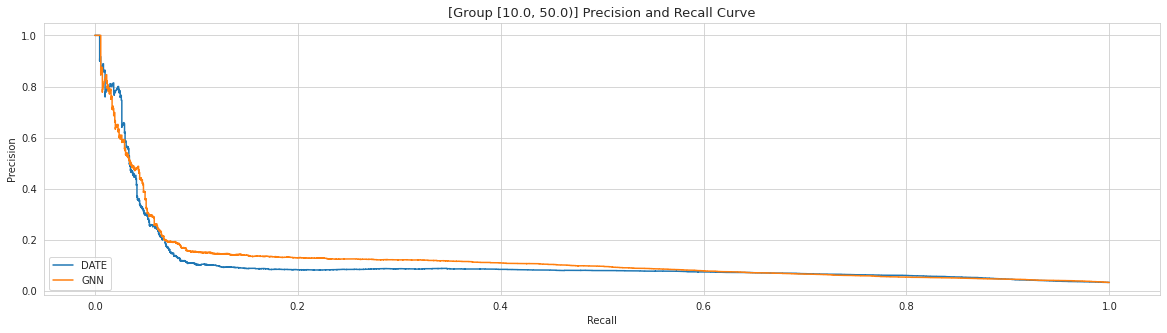

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 144
Precision: 0.2708, Recall: 0.0987, Revenue: 0.1706
Checking top 2% suspicious transactions: 287
Precision: 0.1951, Recall: 0.1418, Revenue: 0.2170
Checking top 5% suspicious transactions: 717
Precision: 0.1604, Recall: 0.2911, Revenue: 0.2869
Checking top 10% suspicious transactions: 1433
Precision: 0.1270, Recall: 0.4608, Revenue: 0.3752
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 143
Precision: 0.2867, Recall: 0.1038, Revenue: 0.2088
Checking top 2% suspicious transactions: 287
Precision: 0.1812, Recall: 0.1316, Revenue: 0.2245
Checking top 5% suspicious transactions: 717
Precision: 0.1088, Recall: 0.1975, Revenue: 0.2471
Checking top 10% suspicious transactions: 1431
Precision: 0.0846, Recall: 0.3063, Revenue: 0.3007


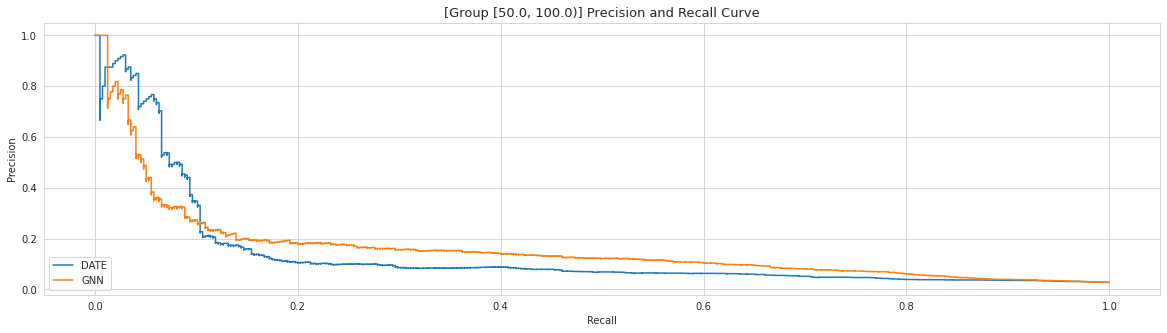

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 237
Precision: 0.3544, Recall: 0.1232, Revenue: 0.0867
Checking top 2% suspicious transactions: 474
Precision: 0.3797, Recall: 0.2639, Revenue: 0.1588
Checking top 5% suspicious transactions: 1184
Precision: 0.2441, Recall: 0.4238, Revenue: 0.2820
Checking top 10% suspicious transactions: 2367
Precision: 0.1517, Recall: 0.5264, Revenue: 0.3425
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 237
Precision: 0.2025, Recall: 0.0704, Revenue: 0.0815
Checking top 2% suspicious transactions: 473
Precision: 0.1374, Recall: 0.0953, Revenue: 0.1066
Checking top 5% suspicious transactions: 1182
Precision: 0.1277, Recall: 0.2214, Revenue: 0.2027
Checking top 10% suspicious transactions: 2367
Precision: 0.1314, Recall: 0.4560, Revenue: 0.3238


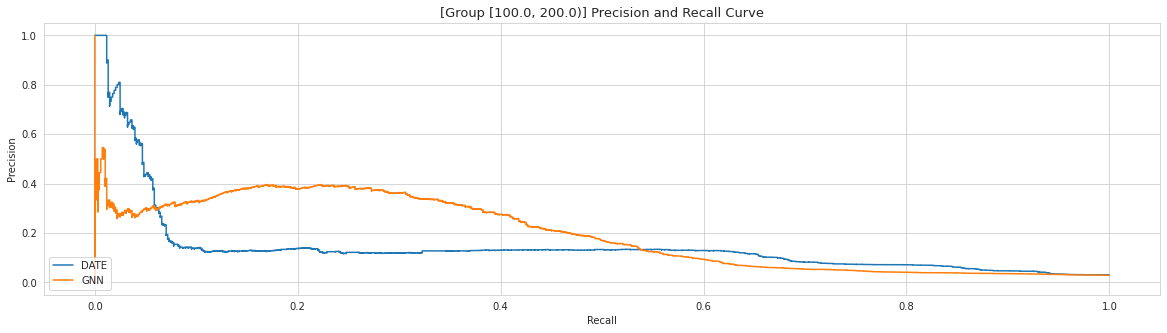

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...
Checking top 1% suspicious transactions: 592
Precision: 0.6875, Recall: 0.4353, Revenue: 0.3209
Checking top 2% suspicious transactions: 1183
Precision: 0.4632, Recall: 0.5861, Revenue: 0.4597
Checking top 5% suspicious transactions: 2957
Precision: 0.2205, Recall: 0.6973, Revenue: 0.5550
Checking top 10% suspicious transactions: 5913
Precision: 0.1219, Recall: 0.7711, Revenue: 0.6179
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 592
Precision: 0.4240, Recall: 0.2684, Revenue: 0.3567
Checking top 2% suspicious transactions: 1181
Precision: 0.3785, Recall: 0.4781, Revenue: 0.4724
Checking top 5% suspicious transactions: 2957
Precision: 0.2158, Recall: 0.6824, Revenue: 0.6322
Checking top 10% suspicious transactions: 5912
Precision: 0.1269, Recall: 0.8021, Revenue: 0.7380


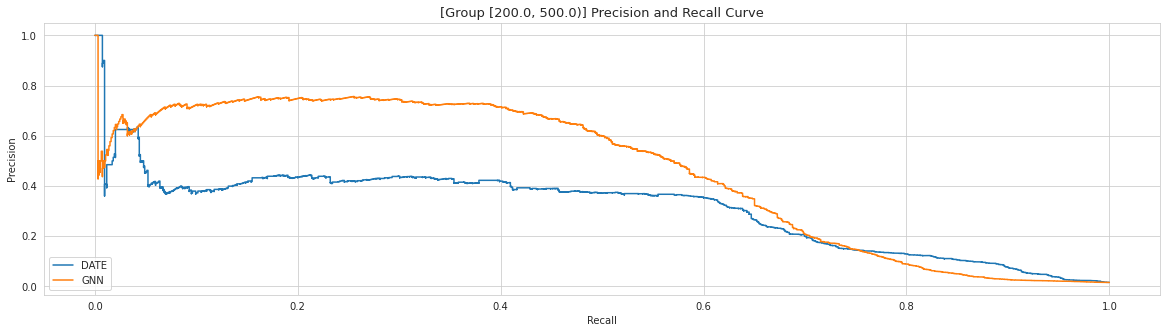

===============Evaluating subgroup:[500.0, inf)===============
GNN Results...
Checking top 1% suspicious transactions: 732
Precision: 0.7063, Recall: 0.5802, Revenue: 0.5120
Checking top 2% suspicious transactions: 1463
Precision: 0.4381, Recall: 0.7194, Revenue: 0.6325
Checking top 5% suspicious transactions: 3658
Precision: 0.1960, Recall: 0.8047, Revenue: 0.7418
Checking top 10% suspicious transactions: 7315
Precision: 0.1023, Recall: 0.8395, Revenue: 0.8089
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 732
Precision: 0.5260, Recall: 0.4321, Revenue: 0.4507
Checking top 2% suspicious transactions: 1462
Precision: 0.4562, Recall: 0.7486, Revenue: 0.7908
Checking top 5% suspicious transactions: 3658
Precision: 0.2080, Recall: 0.8541, Revenue: 0.8931
Checking top 10% suspicious transactions: 7315
Precision: 0.1155, Recall: 0.9484, Revenue: 0.9967


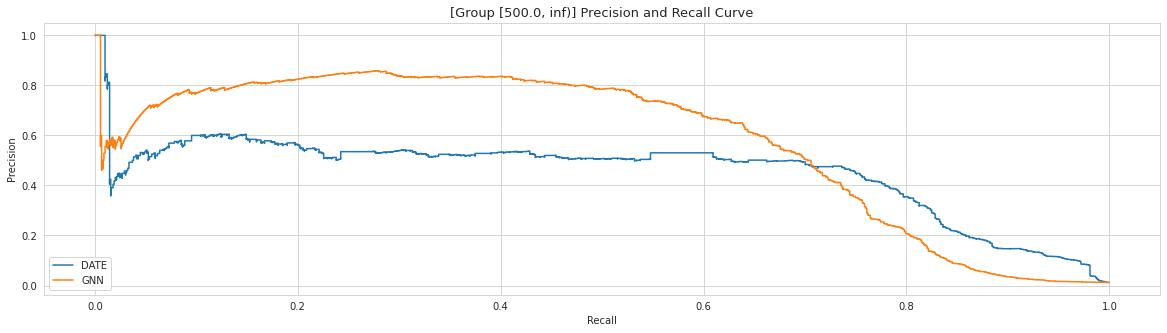

In [29]:
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()

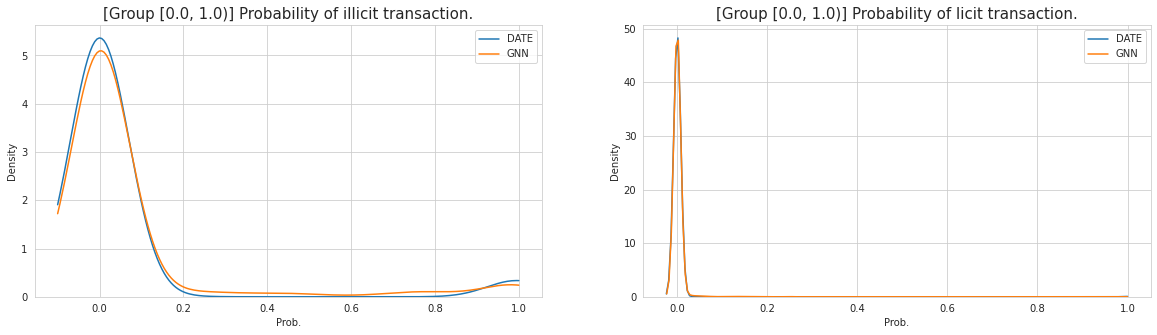

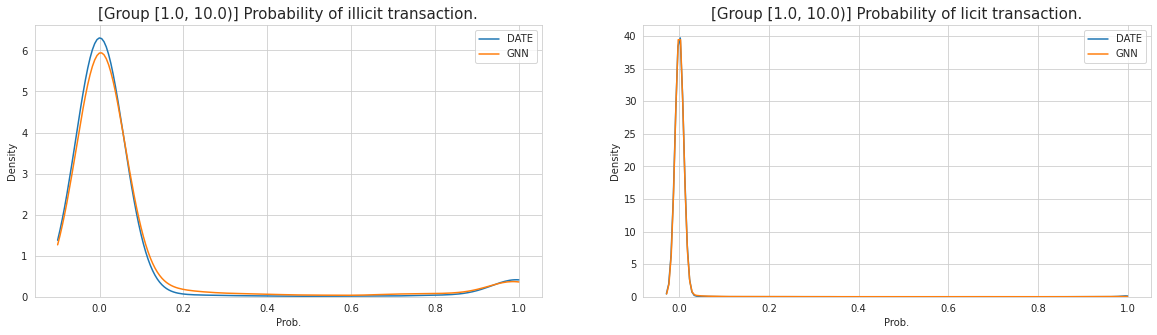

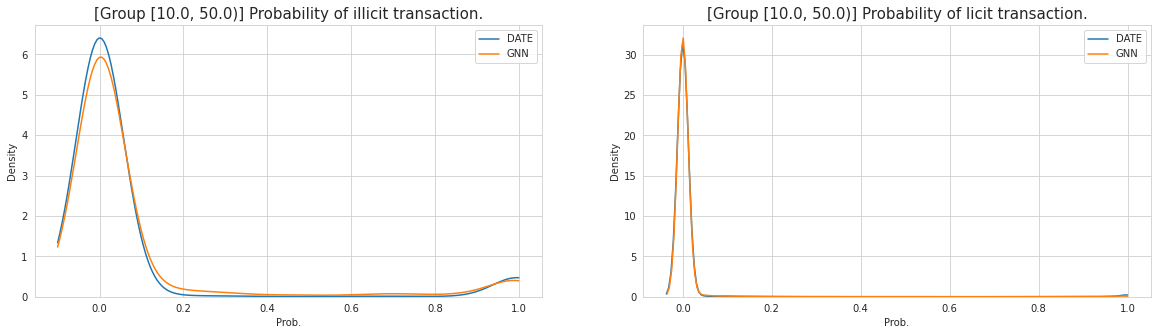

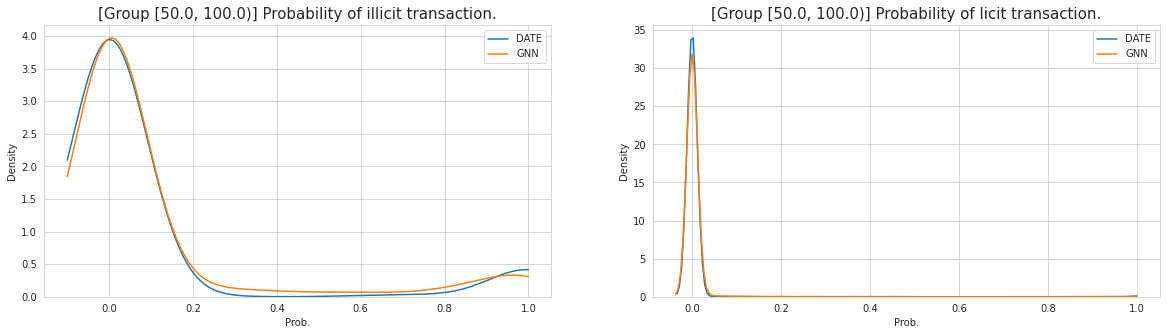

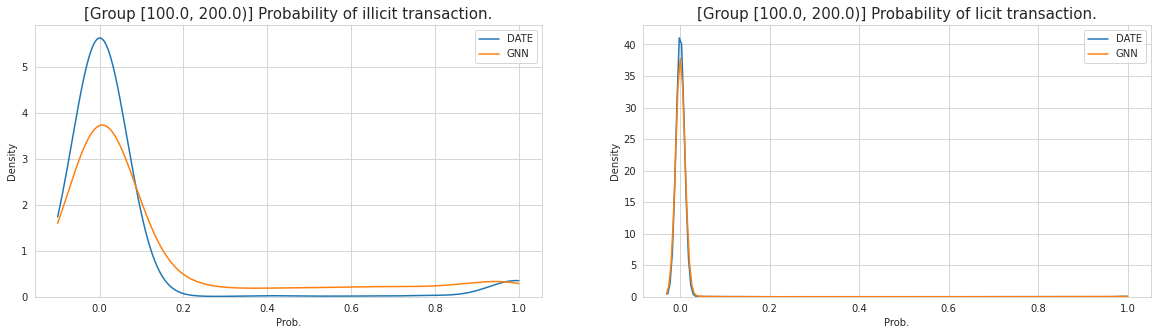

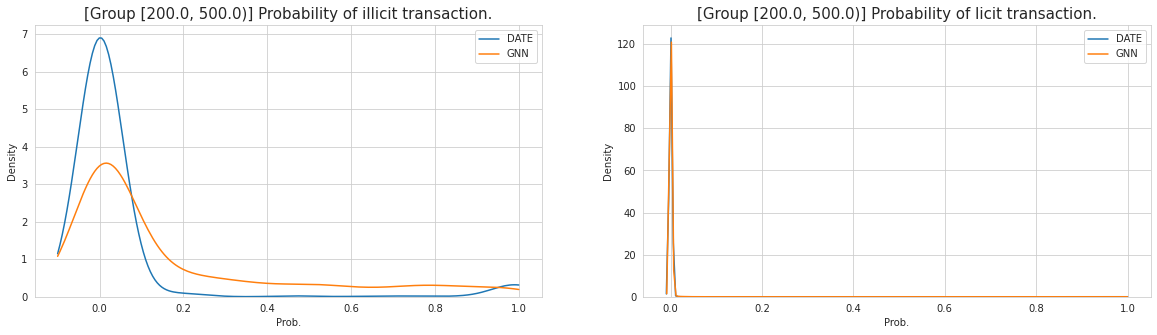

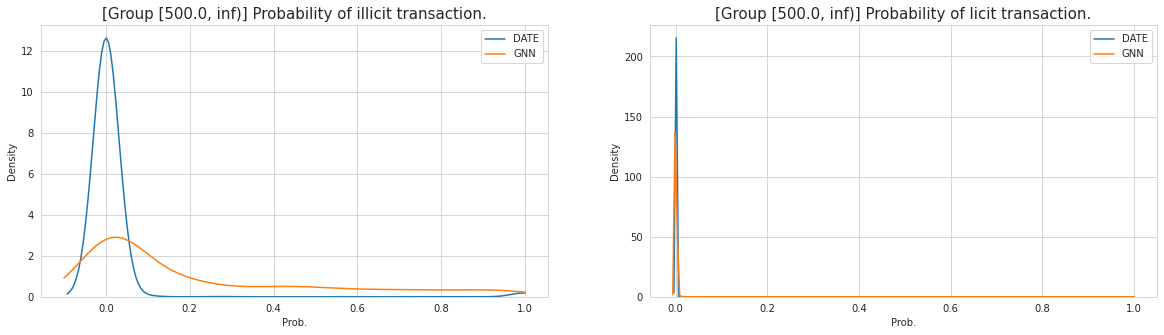

In [30]:
for groupID, subgroup in analysis.groupby("bins"):
    fig = plt.figure(figsize=(20,5))
    
    # illicit
    illict_ax = fig.add_subplot(1,2,1)
    illicit_group = subgroup[subgroup["cls_label"] == 1]
    sns.kdeplot(illicit_group["DATE"], label = "DATE",ax=illict_ax, clip=(-0.1,1))
    sns.kdeplot(illicit_group["gnn"], label = "GNN",ax=illict_ax, clip=(-0.1,1))
    plt.xlabel("Prob.")
    plt.title("[Group %s] Probability of illicit transaction." % groupID, fontsize = 15)
    plt.legend()
    
    # licit
    lict_ax = fig.add_subplot(1,2,2)
    licit_group = subgroup[subgroup["cls_label"] == 0]
    sns.kdeplot(licit_group["DATE"], label = "DATE",ax=lict_ax, clip=(-0.1,1))
    sns.kdeplot(licit_group["gnn"], label = "GNN",ax=lict_ax, clip=(-0.1,1))
    plt.xlabel("Prob.")
    plt.title("[Group %s] Probability of licit transaction." % groupID, fontsize = 15)
    plt.legend()

# Malawi Dataset

In [33]:
data = dataset.Mdata(path='../Custom-Semi-Supervised/data/mdata.csv')
parser = get_parser()
args = parser.parse_args(args=
                         ["--data","real-m", 
                          "--sampling","xgb",
                          "--mode","scratch",
                          "--train_from","20130101",
                          "--test_from","20160101",
                          "--test_length","365",
                          "--valid_length","90",
                          "--initial_inspection_rate", "3",
                          "--final_inspection_rate", "10",
                         ])

In [34]:
# args
seed = args.seed
initial_inspection_rate = args.initial_inspection_rate
inspection_rate_option = args.inspection_plan
mode = args.mode
train_begin = args.train_from 
test_begin = args.test_from
test_length = args.test_length
valid_length = args.valid_length
chosen_data = args.data
numWeeks = args.numweeks

# Initial dataset split
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Initial dataset split
train_start_day = datetime.date(int(train_begin[:4]), int(train_begin[4:6]), int(train_begin[6:8]))
test_start_day = datetime.date(int(test_begin[:4]), int(test_begin[4:6]), int(test_begin[6:8]))
test_length = timedelta(days=test_length)    
test_end_day = test_start_day + test_length
valid_length = timedelta(days=valid_length)
valid_start_day = test_start_day - valid_length

# data
data.split(train_start_day, valid_start_day, test_start_day, test_end_day, valid_length, test_length, args)
data.featureEngineering()

Data size:
Train labeled: (8783, 46), Train unlabeled: (284000, 46), Valid labeled: (27044, 46), Valid unlabeled: (0, 17), Test: (99797, 46)
Checking label distribution
Training: 0.018791323512353554
Validation: 0.024859784750644234
Testing: 0.011534680059599225


In [35]:
categories=["importer.id","HS6"]
gdata = GraphData(data,use_xgb=False, categories=categories)

### Average unseen category 

In [36]:
print("[valid] Unseen importer rate: %.4f" % (1 - gdata.valid_user.nonzero().shape[0] / data.valid.shape[0]))
print("[Valid] Unseen HS code rate: %.4f" % (1 - gdata.valid_item.nonzero().shape[0] / data.valid.shape[0]))
print("[test] Unseen importer rate: %.4f" % (1 - gdata.test_user.nonzero().shape[0] / data.test.shape[0]))
print("[test] Unseen HS code rate: %.4f" % (1 - gdata.test_item.nonzero().shape[0] / data.test.shape[0]))

[valid] Unseen importer rate: 0.3110
[Valid] Unseen HS code rate: 0.0333
[test] Unseen importer rate: 0.3119
[test] Unseen HS code rate: 0.0407


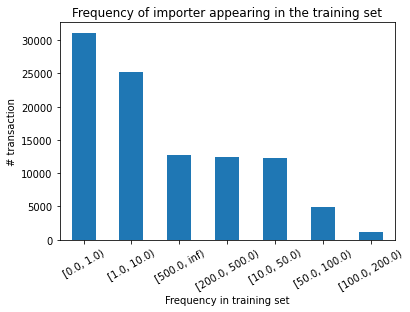

In [37]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_user.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_user.numpy()]
count_Ser = pd.Series(test_counts)

# plots
bins = [0, 1,10,50,100,200,500,np.inf]
cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar")
plt.title("Frequency of importer appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()

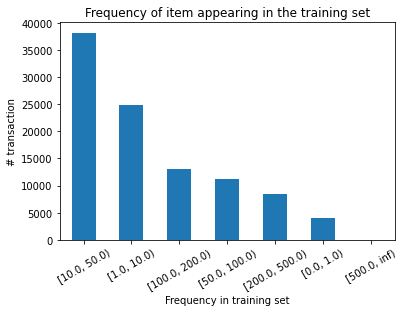

In [38]:
# calculate the frequency of HSCode of test transaction appearing in training set
cnter = Counter(gdata.train_item.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_item.numpy()]
count_Ser = pd.Series(test_counts)

# plots
bins = [0, 1,10,50,100,200,500,np.inf]
cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
cuteted_bin.plot(kind="bar")
plt.title("Frequency of item appearing in the training set")
plt.ylabel("# transaction")
plt.xlabel("Frequency in training set")
plt.xticks(rotation=30)
plt.show()